# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [411]:
import numpy as np
from scipy import optimize
import sympy as sm
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Basic Solow Model


\begin{equation}
Y_t = AK_t^{\alpha}L_t^{1-\alpha} \tag{1}
\end{equation}
\begin{equation}
S_t = sY_t \tag{2}
\end{equation}
\begin{equation}
K_{t+1} - K_t = S_t -\delta K_t \tag{3}
\end{equation}
\begin{equation}
L_{t+1} = (1+n)L_t \tag{4}
\end{equation}
\begin{equation}
y_t = \frac{Y_t}{L_t} = Ak_t^{\alpha} \tag{5}
\end{equation}
\begin{equation}
k_t = \frac{K_t}{L_t} \tag{6}
\end{equation}




In [394]:
Y = sm.symbols("Y_t")          #GDP in the economy
y = sm.symbols("y_t")          #GDP per worker
K = sm.symbols("K_t")          #Capital in the economy
K_next = sm.symbols("K_{t+1}") #Capital in the economy next period
k = sm.symbols("k_t")          #Capital per worker
k_next = sm.symbols("k_{t+1}") #Capital per worker
s = sm.symbols("s")            #Rate of savings
n = sm.symbols("n")            #Population growth
g = sm.symbols("g")            #Growth in technology
A = sm.symbols("A")            #Total factor productivity
L = sm.symbols("L_t")          #Labour
L_next = sm.symbols("L_{t+1}") #Labour next period
alpha = sm.symbols("alpha")    #Return on capital
delta = sm.symbols("delta")    #Depreciation rate on capital
kstar = sm.symbols("k^*")    #Steady state for capital
ystar = sm.symbols("y^*")      #Steady state for GDP per worker



In [395]:
r = sm.symbols("r_t")          #Real rental rate
w = sm.symbols("w_t")          #Real wage

\begin{equation}
r_t = \alpha A \left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{7}
\end{equation}
\begin{equation}
w_t = (1-\alpha) A \left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{8}
\end{equation}

In [396]:
##production_function = sm.Eq(A * K**(alpha) * L**(1-alpha), Y)

In [397]:
foc_wrt_K = sm.Eq(sm.simplify(sm.diff(A * K**(alpha) * L**(1-alpha), K)),r)
foc_wrt_K

Eq(A*K_t**(alpha - 1)*L_t**(1 - alpha)*alpha, r_t)

In [398]:
foc_wrt_L = sm.Eq(sm.simplify(sm.diff(A * K**(alpha) * L**(1-alpha), L)),w)
foc_wrt_L

Eq(-A*K_t**alpha*L_t**(-alpha)*(alpha - 1), w_t)

# Capital Accumulation

By inserting equation 1 in 2 and then inserting that in equation 3, finally we divide by equation 4 to end up at the transition equation

In [399]:
Transition_equation = sm.simplify(sm.Eq((((1/(1+n))*(A*s*k**(alpha)+(1-delta)*k))), k_next))

In [400]:
Transition_equation


Eq(k_{t+1}, (A*k_t**alpha*s - k_t*(delta - 1))/(n + 1))

To find the steady state of capital, we use that $$\begin{equation}
k_{t+1}=k_t=k^*
\end{equation}$$
 in steady state.


In [401]:
steady_state_capital = sm.solve(((A*s*kstar**(alpha)-(delta-1)*kstar)/(1+n)-kstar), kstar)
steady_state_capital[0]

((delta + n)/(A*s))**(1/(alpha - 1))

In [402]:
sm.Eq(steady_state_capital[0], kstar)

Eq(((delta + n)/(A*s))**(1/(alpha - 1)), k^*)

Using this result and using equation 5, we get the following steady state output

In [403]:
steady_state_output = sm.simplify(A*steady_state_capital[0]**alpha)
sm.Eq(ystar, steady_state_output)

Eq(y^*, A*(((delta + n)/(A*s))**(1/(alpha - 1)))**alpha)

In [404]:
steady_state_capital_func = sm.lambdify((delta,n,A,s,alpha),steady_state_capital[0])

def _steady_state_capital_func(delta,n,A,s,alpha):
    return steady_state_capital_func(delta,n,A,s,alpha)




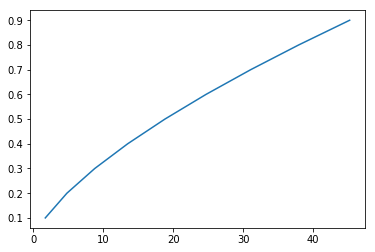

In [493]:
delta= 0.05
n= 0.02
A= 1
savings_vec = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
alpha = 0.33
steady_state_capital_func(delta,n,A,savings_vec,alpha)
plt.plot(steady_state_capital_func(delta,n,A,savings_vec,alpha),savings_vec);

In [475]:
def solow_graph_1(k,delta,n,A,s,alpha,t):
        # capital path
    kvec = [k]
        # savings path
    svec = []
        # depreciation path
    deltavec = []

    for t_ in range(1,t):
        depreciation = (delta+n)*t_
        deltavec.append(depreciation)
   

    for t_ in range(1,t):
        savings = s*A*t_**alpha
        svec.append(savings)
    
    for t_ in range(1, t):
        k_extended = A*t_**alpha
        kvec.append(k_extended)
    


    plt.figure(figsize=(5,5))
    plt.plot(kvec[:t], label='$Ak_t^{\u03B1}$', color = 'blue')
    plt.plot(deltavec[:t], label = '$(n+\delta)k_t$', color = 'black')
    plt.plot(svec[:t], label = '$sAk_t^{\u03B1}$', color = 'green')
    plt.xlim(0,t)
    plt.ylim(0,deltavec[-1])
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    return plt.show()

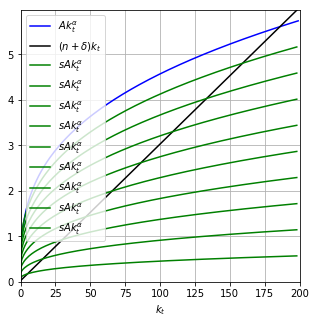

In [476]:
solow_graph_1(1,0.02,0.01,1,savings_vec,0.33,200)

In [491]:
def solow_equation(k, delta, n, A, s, alpha):

    savings = s *A* k ** alpha
    depreciation = (delta+n) * k
    k_extended =  k + savings - depreciation 
    return k_extended, savings, depreciation


def solow_graph_2(k_0,delta,n,A,s,alpha,t):

        #cpaital path
    kvec = [k_0]
        # savings path
    svec = []
        # depreciation path
    deltavec = []

        
    for t_ in range(1, t):

        k_extended, savings, depreciation = solow_equation(kvec[t_-1], delta,n,A, s, alpha)

        kvec.append(k_extended)
        svec.append(savings)
        deltavec.append(depreciation)
    

    plt.figure(figsize=(5,5))
    plt.plot(kvec[:t], label='$Ak_t^{\u03B1}$', color = 'blue')
    plt.plot(deltavec[:t], label = '$(n+\delta)k_t$', color = 'black')
    plt.plot(svec[:t], label = '$sAk_t^{\u03B1}$', color = 'red')
    plt.xlim(0,t)
    plt.ylim(0, )
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    return plt.plot()


In [477]:
widgets.interact(solow_graph_1, 
                k     = widgets.fixed(0), 
                alpha = widgets.FloatSlider(description = '\u03B1' , min = 0 ,    max = 0.9 , step = 0.01 , value = 0.33),
                delta = widgets.FloatSlider(description = '\u03B4' , min = 0 ,    max = 0.1 , step = 0.01 , value = 0.01),
                s     = widgets.FloatSlider(description = 's' ,        min = 0.01, max = 0.9 , step = 0.01 , value = 0.4),
                n     = widgets.FloatSlider(description ='n',        min = -0.1 , max = 0.1 , step = 0.005, value = 0.01),
                A     = widgets.fixed(1),
                t     = widgets.IntSlider(description='t' ,          min = 1,     max = 1001, step = 10,    value = 100))

interactive(children=(FloatSlider(value=0.01, description='δ', max=0.1, step=0.01), FloatSlider(value=0.01, de…

<function __main__.solow_graph_1(k, delta, n, A, s, alpha, t)>

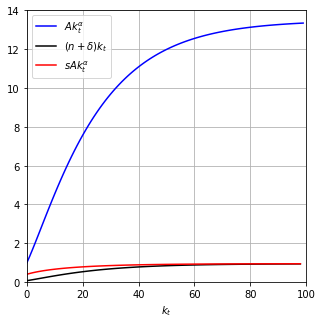

In [492]:
solow_graph_2(1,0.05,0.02,1,0.4,0.33,100);


In [469]:

widgets.interact(
        solow_graph_2,
        k_0=widgets.FloatSlider(
            description="k_0", min=0, max=10, step=0.05, value=2
        ),
        alpha=widgets.FloatSlider(
            description="alpha", min=0.01, max=0.99, step=0.01, value=0.3
        ),
        delta=widgets.FloatSlider(
            description="delta", min=0.01, max=0.50, step=0.01, value=0.05
        ),
        s=widgets.FloatSlider(
            description="s", min=0.01, max=0.99, step=0.01, value=0.33
        ),
        n= widgets.FloatSlider(description ='n', min = -0.1 , max = 0.1 , step = 0.005, value = 0.01),
        A     = widgets.fixed(1),
        t     = widgets.IntSlider(description='t' , min = 1, max = 150, step = 10,  value = 100),
      
    );

interactive(children=(FloatSlider(value=2.0, description='k_0', max=10.0, step=0.05), FloatSlider(value=0.05, …